This Colab document runs the lidar processing for all the data files (basically takes the code of the lidar processing pdf and puts it in a for loop that will go over all plots and fields)

In [ ]:
#mount google drive and import necessary packages
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
from pandas import *
import os.path
from scipy import interpolate 




#read in files to extract uptimes from 
atu2 = read_csv("/content/drive/MyDrive/Group2Module2_CSS844/Robot_lidar/21atu2_vw_2021-08-18/21atu2_vw_2021-08-18.csv") 
atue = read_csv("/content/drive/MyDrive/Group2Module2_CSS844/Robot_lidar/21atue_vw_2021-08-18/21atue_vw_2021-08-18.csv")


#extract lists of uptimes, column/range, and plot ids (the strings that look like like "f1a89bc8-1166-4236-aced-cd1517ce55c0" and correspond to the folder names)
#code reference: https://www.geeksforgeeks.org/python-read-csv-columns-into-list/
atu2_ids_list = atu2['id'].tolist()
atu2_min_uptimes_list = atu2['start (ms)'].tolist()
atu2_max_uptimes_list = atu2['end (ms)'].tolist()
atu2_range_list = atu2['range'].tolist()
atu2_col_list = atu2['column'].tolist()

atue_ids_list = atue['id'].tolist()
atue_min_uptimes_list = atue['start (ms)'].tolist()
atue_max_uptimes_list = atue['end (ms)'].tolist() 
atue_range_list = atu2['range'].tolist()
atue_col_list = atu2['column'].tolist()

Mounted at /content/drive


In [ ]:
#---run lidar processing for atu2 data---
#takes ~11.5 minutes to run

#create objects to save in 
processed_data_atu2 = [0] * len(atu2_ids_list)  #https://www.delftstack.com/howto/python/list-of-zeros-python/
npy_file_names_atu2 = [0] * len(atu2_ids_list)

for i in range(len(atu2_ids_list)):
  current_id = atu2_ids_list[i]
  #creating file path from variables reference: https://stackoverflow.com/questions/3751900/create-file-path-from-variables
  start_path = "/content/drive/MyDrive/Group2Module2_CSS844/Robot_lidar/21atu2_vw_2021-08-18"
  final_secondary_log_path = os.path.join(start_path, current_id, 'secondary_lidar_log.csv')
  secondary_log=np.genfromtxt(final_secondary_log_path, delimiter=",")
  
  #convert data from millimeters -> meters
  data=secondary_log[:,1:]/1000

  #remove infinite data points (lidar measurements ~65.5 meters)
  data_mask = data < 65    
  masked_data=data*data_mask

  #use trig to get horizontal and vertical distances of the point 
  sample_size=data.shape[1]    
  angles=(225-np.arange(sample_size)*270/sample_size)*np.pi/180    
  cos=-np.cos(angles)    
  sin=np.sin(angles)    
  side=cos*data    
  height=sin*data

  #convert GPS longitude and latitude readings into meter distances 
  final_system_log_path = os.path.join(start_path, current_id, 'system_log.csv')
  sl_temp=np.genfromtxt(final_system_log_path, delimiter=",")
  sl_uptimes=sl_temp[1:,1]    
  lats=sl_temp[1:,22]    
  lons=sl_temp[1:,23]    
  origin_lat=lats[0]    
  origin_lon=lons[0]
  def d_cos(angles):        
    """takes cosine of angle in degrees"""        
    return np.cos(np.radians(angles))
  def d_sin(angles):        
    """sine of angle in degrees"""        
    return np.sin(np.radians(angles))
  def d_hav(angles):        
    """haversine of theta in degrees: sin(theta/2)**2"""        
    return (1-d_cos(angles))/2
  R = 6373.0*1000 #Earth radius in meters
  relative_lats=lats-origin_lat    
  relative_lons=lons-origin_lon    
  a = d_hav(relative_lats) + d_cos(origin_lat)*d_cos(lats)*d_hav(relative_lons)    
  distances = 2*R*np.arctan2(np.sqrt(a), np.sqrt(1-a))
  sl_distances = 2*R*np.arctan2(np.sqrt(a), np.sqrt(1-a))

  #interpolate system log and GPS data
  min_uptime=atu2_min_uptimes_list[i]    
  max_uptime=atu2_max_uptimes_list[i]  
  secondary_uptimes = secondary_log[:, 0]
  uptime_distance_interp=interpolate.interp1d(sl_uptimes, sl_distances, bounds_error=False, fill_value=(distances[0], distances[-1])) 
  distances=uptime_distance_interp(secondary_uptimes) 

  #use the plot split interval to filter the data
  sides2=side[(secondary_uptimes>min_uptime) & (secondary_uptimes<max_uptime),:]
  distances2=distances[(secondary_uptimes>min_uptime) & (secondary_uptimes<max_uptime)]  
  heights2=height[(secondary_uptimes>min_uptime) & (secondary_uptimes<max_uptime),:]


  #generate 3-dimensional point cloud
  distances3= np.tile(distances2, (1081,1)).T    

  length=distances2.shape[0]
  xyz = np.zeros((length, sample_size, 3))    
  xyz[:, :, 0] = sides2      # horizontal    
  xyz[:, :, 1] = distances3  # forward  
  xyz[:, :, 2] = heights2    # vertical 

  #save xyz
  ##this saves the xyz to a list
  processed_data_atu2[i] = xyz
  
  ##this creates a name ('saved_file_name') to save the file as. i think this works, not sure if it is the right way to go about it though
  row = str(atu2_range_list[i]) #https://www.geeksforgeeks.org/convert-integer-to-string-in-python/
  column = str(atu2_col_list[i])
  processed_dir = "/content/drive/MyDrive/Group2Module2_CSS844/processed_files"
  saved_file_name = os.path.join(processed_dir, f"atu2-{current_id}-{row}-{column}.npy")
  # saved_file_name = saved_file_name.replace("/","") #https://stackoverflow.com/questions/28909426/how-to-remove-certain-characters-from-a-string-python
  
  #saves the names of the .npy files to a list
  npy_file_names_atu2[i] = saved_file_name

  print("Saving", saved_file_name)

  #Harry's code for saving as npy file
  with open(saved_file_name, "wb") as f:
    np.save(f, xyz)
  
  #i wanted to copy the saved file but this doesn't work for some reason (gives error cp: cannot stat 'f': No such file or directory)
  #!cp f /content/drive/MyDrive/Group2Module2_CSS844/Robot_lidar/processed_files





(322,) (322, 1081) (322, 1081) (322, 1081)


In [ ]:
#checking that list of file names and individual files saved correctly (looks good)
print(npy_file_names_atu2)
np.load('atu2-f1a89bc8-1166-4236-aced-cd1517ce55c0-10-1.npy')

['atu2-f1a89bc8-1166-4236-aced-cd1517ce55c0-10-1.npy', 'atu2-f1a89bc8-1166-4236-aced-cd1517ce55c0-11-1.npy', 'atu2-f1a89bc8-1166-4236-aced-cd1517ce55c0-12-1.npy', 'atu2-f1a89bc8-1166-4236-aced-cd1517ce55c0-13-1.npy', 'atu2-f1a89bc8-1166-4236-aced-cd1517ce55c0-14-1.npy', 'atu2-f1a89bc8-1166-4236-aced-cd1517ce55c0-15-1.npy', 'atu2-f1a89bc8-1166-4236-aced-cd1517ce55c0-16-1.npy', 'atu2-f1a89bc8-1166-4236-aced-cd1517ce55c0-17-1.npy', 'atu2-f1a89bc8-1166-4236-aced-cd1517ce55c0-18-1.npy', 'atu2-feb6f1a8-710b-4bb9-a9dc-c01b09497d05-10-2.npy', 'atu2-feb6f1a8-710b-4bb9-a9dc-c01b09497d05-11-2.npy', 'atu2-feb6f1a8-710b-4bb9-a9dc-c01b09497d05-12-2.npy', 'atu2-feb6f1a8-710b-4bb9-a9dc-c01b09497d05-13-2.npy', 'atu2-feb6f1a8-710b-4bb9-a9dc-c01b09497d05-14-2.npy', 'atu2-feb6f1a8-710b-4bb9-a9dc-c01b09497d05-15-2.npy', 'atu2-feb6f1a8-710b-4bb9-a9dc-c01b09497d05-16-2.npy', 'atu2-feb6f1a8-710b-4bb9-a9dc-c01b09497d05-17-2.npy', 'atu2-feb6f1a8-710b-4bb9-a9dc-c01b09497d05-18-2.npy', 'atu2-04a21bb0-56e5-4e9e-97

array([[[ 0.19233304,  0.30454254, -0.19233304],
        [ 0.19601038,  0.30454254, -0.19430886],
        [ 0.19685556,  0.30454254, -0.19345255],
        ...,
        [-0.18480372,  0.30454254, -0.18003218],
        [-0.19186285,  0.30454254, -0.18854614],
        [-0.18038636,  0.30454254, -0.17882047]],

       [[ 0.17819091,  0.32710021, -0.17819091],
        [ 0.18890855,  0.32710021, -0.18726868],
        [ 0.18972311,  0.32710021, -0.1864434 ],
        ...,
        [-0.18122225,  0.32710021, -0.17654318],
        [-0.1783112 ,  0.32710021, -0.17522876],
        [-0.17967618,  0.32710021, -0.17811645]],

       [[ 0.16404877,  0.34965788, -0.16404877],
        [ 0.16476235,  0.34965788, -0.16333208],
        [ 0.16547279,  0.34965788, -0.16261229],
        ...,
        [-0.19483183,  0.34965788, -0.18980136],
        [-0.19257609,  0.34965788, -0.18924706],
        [-0.18748819,  0.34965788, -0.18586064]],

       ...,

       [[ 0.17111984,  4.86628209, -0.17111984],
        [ 0

In [ ]:
#---run lidar processing for atue data---
#takes ~11.5 minutes to run

#create objects to save in 
processed_data_atue = [0] * len(atue_ids_list)
npy_file_names_atue = [0] * len(atue_ids_list)

for i in range(len(atue_ids_list)):
  current_id = atue_ids_list[i]
  #creating file path from variables reference: https://stackoverflow.com/questions/3751900/create-file-path-from-variables
  start_path = "/content/drive/MyDrive/Group2Module2_CSS844/Robot_lidar/21atue_vw_2021-08-18"
  final_secondary_log_path = os.path.join(start_path, current_id, 'secondary_lidar_log.csv')
  secondary_log=np.genfromtxt(final_secondary_log_path, delimiter=",")
  
  #convert data from millimeters -> meters
  data=secondary_log[:,1:]/1000

  #remove infinite data points (lidar measurements ~65.5 meters)
  data_mask = data < 65    
  masked_data=data*data_mask

  #use trig to get horizontal and vertical distances of the point 
  sample_size=data.shape[1]    
  angles=(225-np.arange(sample_size)*270/sample_size)*np.pi/180    
  cos=-np.cos(angles)    
  sin=np.sin(angles)    
  side=cos*data    
  height=sin*data

  #convert GPS longitude and latitude readings into meter distances 
  final_system_log_path = os.path.join(start_path, current_id, 'system_log.csv')
  sl_temp=np.genfromtxt(final_system_log_path, delimiter=",")
  sl_uptimes=sl_temp[1:,1]    
  lats=sl_temp[1:,22]    
  lons=sl_temp[1:,23]    
  origin_lat=lats[0]    
  origin_lon=lons[0]
  def d_cos(angles):        
    """takes cosine of angle in degrees"""        
    return np.cos(np.radians(angles))
  def d_sin(angles):        
    """sine of angle in degrees"""        
    return np.sin(np.radians(angles))
  def d_hav(angles):        
    """haversine of theta in degrees: sin(theta/2)**2"""        
    return (1-d_cos(angles))/2
  R = 6373.0*1000 #Earth radius in meters
  relative_lats=lats-origin_lat    
  relative_lons=lons-origin_lon    
  a = d_hav(relative_lats) + d_cos(origin_lat)*d_cos(lats)*d_hav(relative_lons)    
  distances = 2*R*np.arctan2(np.sqrt(a), np.sqrt(1-a))
  sl_distances = 2*R*np.arctan2(np.sqrt(a), np.sqrt(1-a))

  #interpolate system log and GPS data
  min_uptime=atue_min_uptimes_list[i]    
  max_uptime=atue_max_uptimes_list[i]  
  secondary_uptimes = secondary_log[:, 0]
  uptime_distance_interp=interpolate.interp1d(sl_uptimes, sl_distances, bounds_error=False, fill_value=(distances[0], distances[-1])) 
  distances=uptime_distance_interp(secondary_uptimes) 

  #use the plot split interval to filter the data
  sides2=side[(secondary_uptimes>min_uptime) & (secondary_uptimes<max_uptime),:]
  distances2=distances[(secondary_uptimes>min_uptime) & (secondary_uptimes<max_uptime)]  
  heights2=height[(secondary_uptimes>min_uptime) & (secondary_uptimes<max_uptime),:]

  #generate 3-dimensional point cloud
  distances3= np.tile(distances2, (1081,1)).T    
  length=distances2.shape[0]
  xyz = np.zeros((length, sample_size, 3))    
  xyz[:, :, 0] = sides2      # horizontal    
  xyz[:, :, 1] = distances3  # forward  
  xyz[:, :, 2] = heights2    # vertical 

  #save xyz
  processed_data_atue[i] = xyz

  ##this creates a name ('saved_file_name') to save the file as. i think this works, not sure if it is the right way to go about it though
  row = str(atue_range_list[i]) #https://www.geeksforgeeks.org/convert-integer-to-string-in-python/
  column = str(atue_col_list[i])
  processed_dir = "/content/drive/MyDrive/Group2Module2_CSS844/processed_files"
  saved_file_name = os.path.join(processed_dir, f"atue-{current_id}-{row}-{column}.npy")
  # saved_file_name = saved_file_name.replace("/","") #https://stackoverflow.com/questions/28909426/how-to-remove-certain-characters-from-a-string-python
  
  #saves the names of the .npy files to a list
  npy_file_names_atue[i] = saved_file_name

  print("Saving", saved_file_name)

  #Harry's code for saving as npy file
  with open(saved_file_name, "wb") as f:
    np.save(f, xyz)

Saving /content/drive/MyDrive/Group2Module2_CSS844/processed_files/atue-1a12a861-6347-4def-8021-d03bcb98069f-10-1.npy
Saving /content/drive/MyDrive/Group2Module2_CSS844/processed_files/atue-1a12a861-6347-4def-8021-d03bcb98069f-11-1.npy
Saving /content/drive/MyDrive/Group2Module2_CSS844/processed_files/atue-1a12a861-6347-4def-8021-d03bcb98069f-12-1.npy
Saving /content/drive/MyDrive/Group2Module2_CSS844/processed_files/atue-1a12a861-6347-4def-8021-d03bcb98069f-13-1.npy
Saving /content/drive/MyDrive/Group2Module2_CSS844/processed_files/atue-1a12a861-6347-4def-8021-d03bcb98069f-14-1.npy
Saving /content/drive/MyDrive/Group2Module2_CSS844/processed_files/atue-1a12a861-6347-4def-8021-d03bcb98069f-15-1.npy
Saving /content/drive/MyDrive/Group2Module2_CSS844/processed_files/atue-1a12a861-6347-4def-8021-d03bcb98069f-16-1.npy
Saving /content/drive/MyDrive/Group2Module2_CSS844/processed_files/atue-1a12a861-6347-4def-8021-d03bcb98069f-17-1.npy
Saving /content/drive/MyDrive/Group2Module2_CSS844/proce

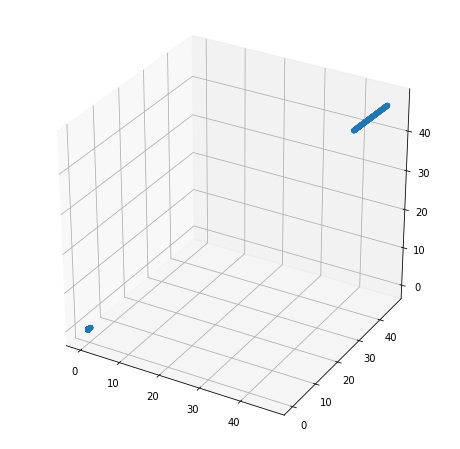

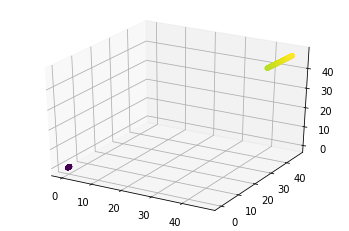

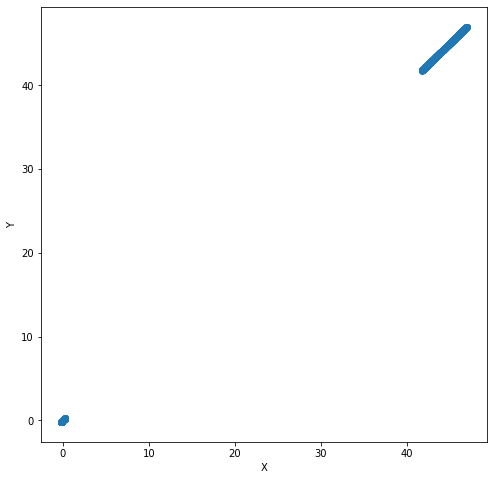

In [ ]:
################################################################################
############################ PLOTTING DENSITY PLOTS ############################
################################################################################

'''
CURRENTLY THE CODE BELOW IS ONLY ON 1 NUMPY ARRAY FILE,
THE NEXT STEP WOULD BE TO GET ALL NUMPY ARRAYS TO MAP TO A SINGLE FIGURE
'''

######################
### 3D POINT CLOUD ### 
######################

# Adapted code from: https://stackoverflow.com/questions/62433465/how-to-plot-3d
# -point-clouds-from-an-npy-file 

import matplotlib.pyplot as plt
import numpy as np

### using one random numpy file as an example ###
data = np.load('/content/drive/MyDrive/Group2Module2_CSS844/processed_files'
               '/atue-07b7b610-5026-43cf-a767-229e1bafa8cc-17-5.npy')
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

# setting the size of figure shown
fig = plt.figure(figsize=(8, 8))
# type of figure (3D)
ax = fig.add_subplot(111, projection='3d')

# Plot scatter plot
ax.scatter(x, y, z)
plt.show()

# ADAPTED CODE FROM https://jakevdp.github.io/PythonDataScienceHandbook/
# 04.12-three-dimensional-plotting.html 

ax2 = plt.axes(projection='3d')
ax2.plot_surface(x, y, z, rstride=1, cstride=1,
                 cmap='viridis', edgecolor='none')
ax2.set_title('TITLE');

ax3 = plt.axes(projection='3d')
ax3.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5);

###############
### 2D VIEW ###
###############

# ADAPTED CODE FROM LINKS ABOVE AS WELL FOR THIS SECTION

# figure sizes and type
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
img = ax.scatter(x, y)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

In [ ]:
for file in '/content/drive/MyDrive/Group2Module2_CSS844/processed_files'

dataloop = np.load('/content/drive/MyDrive/Group2Module2_CSS844/processed_files'
               '/atue-07b7b610-5026-43cf-a767-229e1bafa8cc-17-5.npy')

x = dataloop[:, 0]
y = dataloop[:, 1]
z = dataloop[:, 2]


# setting the size of figure shown
fig = plt.figure(figsize=(8, 8))
# type of figure (3D)
ax = fig.add_subplot(111, projection='3d')

# Plot scatter plot
ax.scatter(x, y, z)
plt.show()


ax2 = plt.axes(projection='3d')
ax2.plot_surface(x, y, z, rstride=1, cstride=1,
                 cmap='viridis', edgecolor='none')
ax2.set_title('TITLE');

ax3 = plt.axes(projection='3d')
ax3.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5);

SyntaxError: ignored